# Part 1: Getting started

## Model Training

<img src="images/training.png" style="width:600px">
Add a better image

### Setup

Import packages from [TensorFlow](https://www.tensorflow.org), [scikit-learn](https://scikit-learn.org), and [NumPy](https://numpy.org).

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

Use a [magic function](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) to include matplotlib graphs in the notebook.

In [2]:
%matplotlib inline

Force a deterministic behaviour with a constant seed. In TensorFlow, `tf.random.set_seed` sets a global-random seed; you can also specify operation-level seeds. More [details](https://www.tensorflow.org/api_docs/python/tf/random/set_seed).

In [3]:
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

Specify where the to find the executable of Xilinx Vivado HLS. The path on the Columbia servers is `/opt/Xilinx/Vivado/2019.1/bin`, but you can change it if you have a local installation of this notebook.

In [4]:
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

### Fetch the jet tagging dataset from OpenML

The [jet tagging dataset](https://www.openml.org/d/42468) is publicly available on [OpenML](https://www.openml.org).

In [5]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

Let's print some information about the dataset (e.g. feature names and the dataset shape).

In [6]:
print('*** Feature names ***')
print(data['feature_names'])

print('*** Shape of the data and label (target) arrays ***')
print(X.shape, y.shape)

print('*** First five data samples ***')
print(X[:5])

print('*** First five labels (targets) ***')
print(y[:5])

*** Feature names ***
['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
*** Shape of the data and label (target) arrays ***
(830000, 16) (830000,)
*** First five data samples ***
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.21

### Preprocessing

As you saw above, the `y` target is an array of strings, e.g. \[`g`, `w`,...\] etc.
We need to make this a _One Hot encoding_ for the training phase.

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


Split the dataset into training and validation sets.

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('*** Shape of the splitted arrays ***')
print(X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape)

*** Shape of the splitted arrays ***
(664000, 16) (166000, 16) (664000, 5) (166000, 5)


Preprocess the data `X`
```
Zi = (Xi - u) / s
```
where `u` is the mean of the training samples and `s` is the standard deviation of the training samples.

In [9]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

Save NumPy arrays to files for this notebooks and the next ones.

In [10]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

### Construct the model

Import additional [Keras](https://keras.io) packages. Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

We create a simple _multi-layer perceptron (MLP)_ model.
- We use the [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) that is essentially a stack of layers, where each layer has exactly one input tensor and one output tensor. See also the [Functional API](https://www.tensorflow.org/guide/keras/functional).
- We use _3_ hidden layers with _64_, then _32_, then _32_ neurons. See a plot of the model in the next few cell.
- Each layer will use ReLU activation.
- Add an output layer with _5_ neurons (one for each class), then finish with Softmax activation.
- [Initializers](https://keras.io/api/layers/initializers) define the way to set the initial random weights of Keras layers. In this case, we choose [LecunUniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/LecunUniform).
- [Regularizers](https://keras.io/api/layers/regularizers) help to get models that generalize to new, unseen data (see the [overfitting problem](https://en.wikipedia.org/wiki/Overfitting)); the regularizes allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. In this case, we choose [L1 regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1) that producer _sparse models_, i.e. model where unnecessary features are set to zero, thus do not contribute to the model predictive power.

In [12]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

Plot model. See this post on [How do you visualize neural network architectures?
](https://datascience.stackexchange.com/questions/12851/how-do-you-visualize-neural-network-architectures)

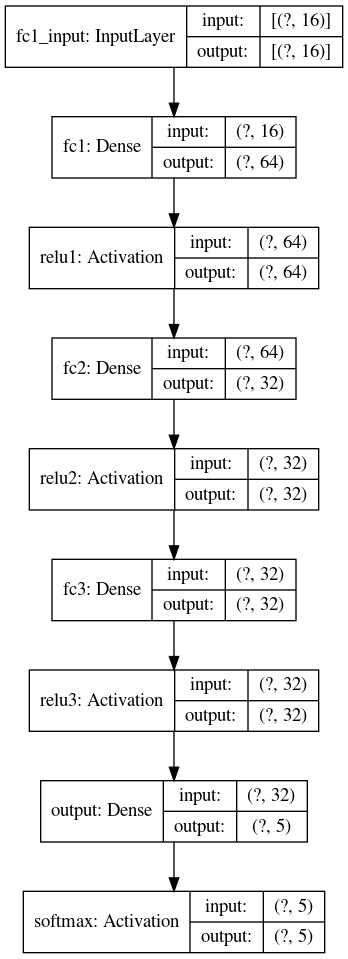

In [13]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### Train the model
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [14]:
train = True

We use [Adam optimizer](https://keras.io/api/optimizers/adam) with [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss. The callbacks will decay the learning rate and save the model into a directory `model_1`. The model isn't very complex, so this should just take a few minutes even on the CPU.

In [15]:
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6388 - accuracy: 0.3027WARNING:tensorflow:From /home/giuseppe/miniconda3/envs/hls4ml-tutorial-cu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
470/487 [===========================>..] - ETA: 0s - loss: 1.3361 - accuracy: 0.5120
***callbacks***
saving losses to model_1/losses.log

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 1.3290 - accurac

480/487 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.7399
***callbacks***
saving losses to model_1/losses.log

Epoch 00012: val_loss improved from 0.80993 to 0.80385, saving model to model_1/KERAS_check_best_model.h5

Epoch 00012: val_loss improved from 0.80993 to 0.80385, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00012: saving model to model_1/KERAS_check_model_last.h5

Epoch 00012: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.8023 - accuracy: 0.7399 - val_loss: 0.8039 - val_accuracy: 0.7401
Epoch 13/30
487/487 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7413
***callbacks***
saving losses to model_1/losses.log

Epoch 00013: val_loss improved from 0.80385 to 0.79875, saving model to model_1/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 0.80385 to 0.79875, saving model to model_1/KERAS_check_bes

Epoch 25/30
456/487 [===========================>..] - ETA: 0s - loss: 0.7636 - accuracy: 0.7504
***callbacks***
saving losses to model_1/losses.log

Epoch 00025: val_loss improved from 0.76954 to 0.76789, saving model to model_1/KERAS_check_best_model.h5

Epoch 00025: val_loss improved from 0.76954 to 0.76789, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7635 - accuracy: 0.7505 - val_loss: 0.7679 - val_accuracy: 0.7493
Epoch 26/30
465/487 [===========================>..] - ETA: 0s - loss: 0.7616 - accuracy: 0.7510
***callbacks***
saving losses to model_1/losses.log

Epoch 00026: val_loss improved from 0.76789 to 0.76631, saving model to model_1/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.76789 to 0.76631, saving model to model_1/KER

### Check performance
Check the accuracy and make a [ROC curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

Accuracy: 0.7502650602409638


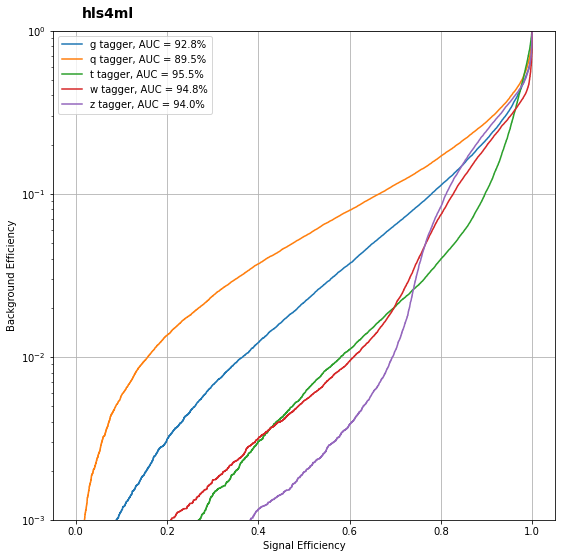

In [16]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

## Convert the model to FPGA firmware with hls4ml

<img src="images/convert.png" style="width:600px">
Add a better image

Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.

First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 

Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [17]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       fpga_part='xcu250-figd2104-2L-e')

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Configuration
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
-----------------------------------
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, current shape: [[None, 16]]
Layer name: fc1, layer type: Dense, current shape: [[None, 16]]
Layer name: relu1, layer type: Activation, current shape: [[None, 64]]
Layer name: fc2, 

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

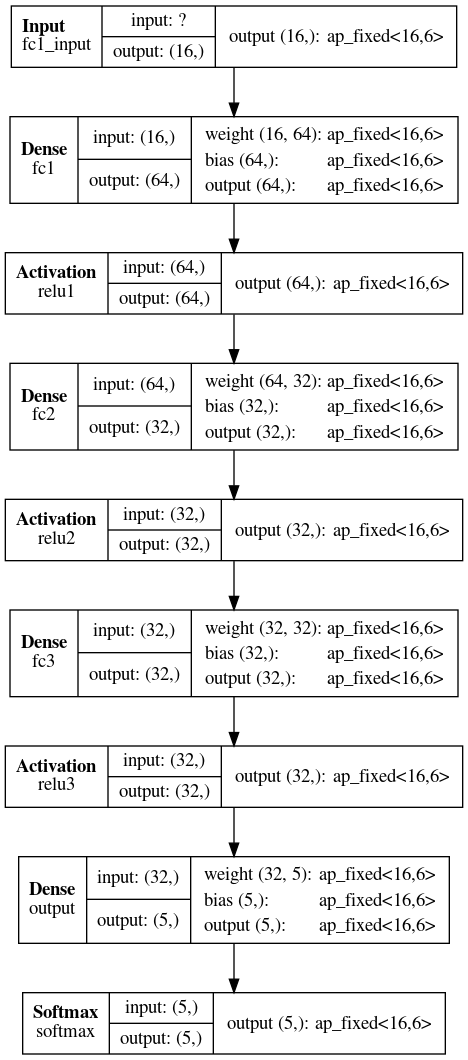

In [18]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Compile & Predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [19]:
hls_model.compile()
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


Exception: Array must be c_contiguous, try using numpy.ascontiguousarray(x)

### Compare Performance
That was easy! Now let's see how the performance compares to Keras:

In [ ]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

### Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [ ]:
hls_model.build(csim=False)

### Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)